**Datathon 2025**

Importing packages

In [1]:
# Normalization and Standartization imports
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

# Package for missing data, although we do not do use it 
#from sklearn.impute import SimpleImputer

from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, root_mean_squared_error

# Base packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Load trainning and testing datasets

In [2]:
trainning = pd.read_csv('CSV\\trajnimi.csv')
testing = pd.read_csv('CSV\\testimi.csv')

# Dropping the url column as it was not needed, errors if not removed further on
trainning = trainning.drop("url", axis=1)
testing = testing.drop("url", axis=1)

trainning, validation = train_test_split(trainning, test_size=0.1, random_state=42)

rows = trainning.shape[0]
print("Number of articles is ", rows)

Number of articles is  28543


Removing articles with zero words

In [3]:
zero_word_articles = trainning[trainning['n_tokens_content'] == 0]
zero_word_count = len(zero_word_articles)

short_articles = trainning[trainning['n_tokens_content'] < 30]
short_articles_count = len(short_articles)

print(f"Number of articles with 0 words: {zero_word_count}")
print(f"Number of articles with less than 30 words: {short_articles_count}")

# Remove articles with less than 15 words
trainning = trainning[trainning["n_tokens_content"] >= 15].copy()
testing = testing[testing["n_tokens_content"] >= 15].copy()

Number of articles with 0 words: 862
Number of articles with less than 30 words: 867


Z-score outlier check

In [12]:
from scipy import stats

# Function to remove outliers using Z-score for all columns at once
def remove_outliers_zscore(df, threshold=3):
    # Create a mask of all True values
    mask = pd.Series(True, index=df.index)
    
    # Update mask for each numeric column
    for col in df.select_dtypes(include=[np.number]).columns:
        z_scores = np.abs(stats.zscore(df[col]))
        mask = mask & (z_scores < threshold)
    
    # Return filtered dataframe
    return df[mask]

df_cleaned = remove_outliers_zscore(trainning)
testing_cleaned = remove_outliers_zscore(testing)
print("Original Shape:", trainning.shape)
print("Cleaned Shape:", df_cleaned.shape)

Original Shape: (27681, 61)
Cleaned Shape: (14853, 61)


Finding outliers using Interquartile range (IQR) method

In [ ]:
Q1 = trainning["shares"].quantile(0.25)
Q3 = trainning["shares"].quantile(0.75)

IQR = Q3 - Q1

upper_cutoff = Q3 +1.5 * IQR
lower_cutoff = Q1 -1.5 * IQR

print("The upper cutoff is the value above which observations are considered outliers.\n")
print(f"Outlier threshhold: {upper_cutoff}")

Eliminating outliers by hand

In [4]:
initial_train_size = trainning.shape[0]
initial_test_size = testing.shape[0]

#trainning = trainning[trainning["shares"] <= 300000].copy() # first change, removing outlier for nr of shares above 300,000
trainning = trainning[trainning["shares"] <= 80000].copy()
trainning = trainning[trainning["n_tokens_content"] <= 4000].copy()
trainning = trainning[trainning["kw_min_max"] <= 400000] #without this its 5400 score
trainning = trainning[trainning["kw_max_max"] <= 400000] #without this its 5400 score
#trainning = trainning[trainning["self_reference_max_shares"] <= 400000] #without this its 5400 score
#trainning = trainning[trainning["self_reference_max_shares"] <= 400000] #without this its 5400 score
trainning = trainning[trainning["n_tokens_content"] >= 15].copy()
testing = testing[testing["n_tokens_content"] >= 15].copy()

# had made a mistake before and corrected with this
#zero_word_articles = trainning[trainning['n_tokens_content'] == 0]
#zero_word_count = len(zero_word_articles)
#print("zero word articles number:", zero_word_count)

removed_train = initial_train_size - trainning.shape[0]
#removed_test = initial_test_size - testing.shape[0]

print(f"\nArticles removed from training set: {removed_train}")
#print(f"Articles removed from testing set: {removed_test}")
print(f"Remaining training articles: {trainning.shape[0]}")
#print(f"Remaining testing articles: {testing.shape[0]}")

# STEP 2: Split the cleaned training data into training and validation
trainning, validation = train_test_split(trainning, test_size=0.1, random_state=42)

print("Mean of Shares:", trainning["shares"].mean())
print("Standard Deviation of Shares:", trainning["shares"].std())



Articles removed from training set: 25437
Remaining training articles: 2244
Mean of Shares: 2868.787518573551
Standard Deviation of Shares: 4798.763794801537


Generating different graphs for visualization

Normalizer - Standardizer

In [5]:
normalizer = Normalizer()
standard = StandardScaler()

Dimensionality reduction

In [6]:
pca = PCA(n_components=2)
lda = LinearDiscriminantAnalysis(n_components=2)
svd = TruncatedSVD(n_components=2)

Regression models

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors, KDTree, NearestCentroid
from sklearn import tree # decision tree and random forest
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR

Pipeline

In [8]:
# can add more but with testing these have been the most effective
# 59 is the column length
pca_components = [2, 15, 59]

models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "Decision Tree": tree.DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "MLP": MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42),
    "GaussianNB": GaussianNB(),
    #"Gaussian PR": GaussianProcessRegressor(),
    "Kernel Ridge": KernelRidge(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVR": SVR(),
    "ElasticNet": ElasticNet(),
    "Bayesian Ridge": BayesianRidge(),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
}

# saving the best results for each model
best_results = {}

# Evaluate models
for n in pca_components:
    
    best_score = float('inf')
    best_model = None
    best_model_name = None
    
    # Create pipeline with Normalizer and PCA
    for model_name, model in models.items():
        pipeline = Pipeline([
            ("normalizer", StandardScaler()),
            ("pca", PCA(n_components=n)),
            ("model", model)
        ])

        # Train and test
        pipeline.fit(trainning.drop('shares', axis=1), trainning['shares'])
        predictions = pipeline.predict(validation.drop('shares', axis=1))
        
        score = root_mean_squared_error(validation['shares'], predictions)  # RMSE
        
        if model_name not in best_results or score < best_results[model_name][1]:
            best_results[model_name] = (n, score, pipeline)

best_results_df = pd.DataFrame.from_dict(best_results, orient='index', columns=["Best PCA Components", "Best Score", "Best Model"])
print(best_results_df)

# model with the lowest score
best_model_name = min(best_results.items(), key=lambda x: x[1][1])[0]
best_score = best_results[best_model_name][1]
best_pca = best_results[best_model_name][0]

print(f"\nBest overall model: {best_model_name} with {best_pca} PCA components")
print(f"Best overall score (RMSE): {best_score:.4f}")

c:\Users\aldod\Documents\machinelearning\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\aldod\Documents\machinelearning\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


                     Best PCA Components   Best Score  \
Linear Regression                     59  4147.831270   
Lasso                                 59  4147.216706   
Ridge                                 59  4147.073929   
Decision Tree                          2  4809.505914   
Random Forest                         15  4272.289486   
MLP                                   15  4217.186153   
GaussianNB                             2  4446.398680   
Kernel Ridge                          59  5053.359506   
Logistic Regression                   59  4468.385550   
SVR                                    2  4459.979199   
ElasticNet                            59  4154.066767   
Bayesian Ridge                        59  4160.880780   
XGBoost                                2  4250.568848   

                                                            Best Model  
Linear Regression    (StandardScaler(), PCA(n_components=59), Linea...  
Lasso                (StandardScaler(), PCA(n_component

Hyper-parameter tunning, Grid Search

In [16]:
import numpy as np
from sklearn.linear_model import Lasso, Ridge
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

def grid_search_regression(X, y, cv=5, scoring='neg_mean_squared_error'):
    """
    Perform grid search for Lasso and Ridge regression with dimensionality reduction
    and preprocessing techniques.
    
    Parameters:
    -----------
    X : array-like
        Features matrix
    y : array-like
        Target vector
    cv : int, default=5
        Number of cross-validation folds
    scoring : str, default='neg_mean_squared_error'
        Scoring metric for grid search
        
    Returns:
    --------
    dict
        Dictionary containing best models and results
    """
    # Get max number of components based on data dimensions
    n_samples, n_features = X.shape
    max_components = min(n_features, n_samples - 1)
    
    # Define dimensionality reduction components to try
    components = [2, 15, max_components]
    components = [c for c in components if c <= max_components]
    
    # Define preprocessing steps
    preprocessors = [
        ('none', None),
        ('standardize', StandardScaler()),
        ('normalize', Normalizer())
    ]
    
    # Define dimensionality reduction techniques
    dim_reduction = [
        ('none', None),
        ('pca', PCA()),
        ('svd', TruncatedSVD()),
        ('lda', LinearDiscriminantAnalysis())
    ]
    
    # Define models with their parameter grids
    models = [
        ('lasso', Lasso(max_iter=10000, random_state=42), {
            'model__alpha': np.logspace(-4, 1, 6)
        }),
        ('ridge', Ridge(random_state=42), {
            'model__alpha': np.logspace(-4, 1, 6)
        })
    ]
    
    results = {}
    
    # Loop through preprocessing methods
    for preproc_name, preprocessor in preprocessors:
        # Skip LDA for no preprocessing (might cause numerical issues)
        dim_red_options = dim_reduction if preproc_name != 'none' else [d for d in dim_reduction if d[0] != 'lda']
        
        # Loop through dimensionality reduction techniques
        for dim_red_name, dim_reducer in dim_red_options:
            # Skip if no dimensionality reduction
            if dim_red_name == 'none':
                dim_red_params = {}
                components_to_try = [None]
            else:
                # Handle LDA differently (n_components limited by number of classes)
                if dim_red_name == 'lda':
                    n_classes = len(np.unique(y))
                    components_to_try = [min(c, n_classes - 1) for c in components if c < n_classes]
                    if not components_to_try:
                        continue  # Skip if no valid components for LDA
                else:
                    components_to_try = components
                
                dim_red_params = {f'dim_reduction__n_components': components_to_try}
            
            # Loop through regression models
            for model_name, model, model_params in models:
                # Create pipeline
                steps = []
                if preprocessor:
                    steps.append(('preprocessor', preprocessor))
                if dim_reducer:
                    steps.append(('dim_reduction', dim_reducer))
                steps.append(('model', model))
                
                pipeline = Pipeline(steps)
                
                # Combine parameters
                param_grid = {**dim_red_params, **model_params}
                
                # Create descriptive configuration name
                config_name = f"{model_name}_{preproc_name}_{dim_red_name}"
                if dim_red_name != 'none':
                    config_name += f"_components_{'-'.join(map(str, components_to_try))}"
                
                # Perform grid search
                print(f"Running grid search for: {config_name}")
                grid_search = GridSearchCV(
                    pipeline, param_grid, cv=cv, scoring=scoring, 
                    n_jobs=-1, verbose=1, return_train_score=True
                )
                
                try:
                    grid_search.fit(X, y)
                    
                    # Store results
                    results[config_name] = {
                        'best_params': grid_search.best_params_,
                        'best_score': grid_search.best_score_,
                        'best_estimator': grid_search.best_estimator_,
                        'cv_results': grid_search.cv_results_
                    }
                    
                    print(f"Best score for {config_name}: {grid_search.best_score_:.4f}")
                    print(f"Best parameters: {grid_search.best_params_}")
                    print("-" * 50)
                    
                except Exception as e:
                    print(f"Error in {config_name}: {str(e)}")
    
    # Rank all results and find overall best model
    if results:
        all_scores = [(name, info['best_score']) for name, info in results.items()]
        all_scores.sort(key=lambda x: x[1], reverse=True)
        
        print("\nRanked Models:")
        for rank, (name, score) in enumerate(all_scores, 1):
            print(f"{rank}. {name}: {score:.4f}")
        
        best_model_name = all_scores[0][0]
        print(f"\nOverall best model: {best_model_name}")
        print(f"Best score: {results[best_model_name]['best_score']:.4f}")
        print(f"Best parameters: {results[best_model_name]['best_params']}")
        
        # Add overall best model to results
        results['overall_best'] = {
            'model_name': best_model_name,
            'best_estimator': results[best_model_name]['best_estimator'],
            'best_score': results[best_model_name]['best_score'],
            'best_params': results[best_model_name]['best_params']
        }
    
    return results

# Example usage
if __name__ == "__main__":
    
    # Run grid search
    results = grid_search_regression(trainning.drop('shares', axis=1), trainning['shares'])
    
    # Use the best model for prediction
    best_model = results['overall_best']['best_estimator']
    
    # Example prediction
    y_pred = best_model.predict(validation.drop('shares', axis=1))
    
    # Evaluate
    print("\nFinal Model Evaluation on Training Data:")
    print(f"R² Score: {r2_score(validation['shares'], y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(validation['shares'], y_pred)):.4f}")
    
    # Generate summary table of results
    summary = []
    for model_name, info in results.items():
        if model_name != 'overall_best':
            summary.append({
                'Model': model_name,
                'Best Score': info['best_score'],
                'Best Parameters': str(info['best_params'])
            })
    
    summary_df = pd.DataFrame(summary)
    summary_df = summary_df.sort_values('Best Score', ascending=False)
    
    print("\nSummary of all model configurations:")
    print(summary_df)

    real_mse = -results['overall_best']['best_score']
    print(f"Best MSE: {real_mse:.4f}")
    print(f"Best RMSE: {np.sqrt(real_mse):.4f}")

Running grid search for: lasso_none_none
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best score for lasso_none_none: -29209355.2711
Best parameters: {'model__alpha': np.float64(10.0)}
--------------------------------------------------
Running grid search for: ridge_none_none
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best score for ridge_none_none: -36421922.6010
Best parameters: {'model__alpha': np.float64(10.0)}
--------------------------------------------------
Running grid search for: lasso_none_pca_components_2-15-60
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best score for lasso_none_pca_components_2-15-60: -29226195.2516
Best parameters: {'dim_reduction__n_components': 60, 'model__alpha': np.float64(10.0)}
--------------------------------------------------
Running grid search for: ridge_none_pca_components_2-15-60
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best score for ridge_none_pca_components_2-15-60: -2940

Visualising the results

C:\Users\aldod\AppData\Local\Temp\ipykernel_27920\50397118.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


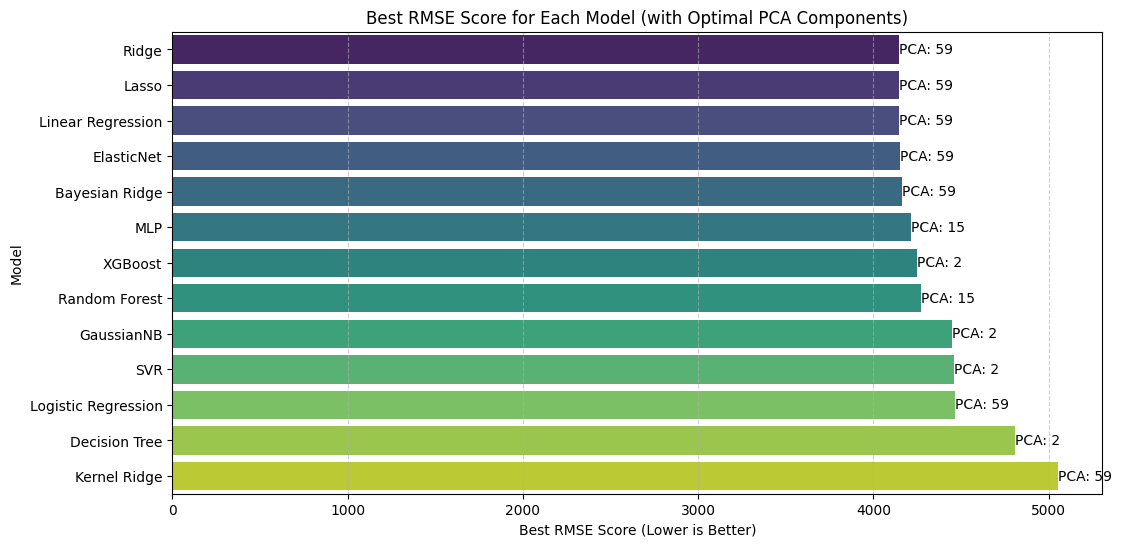

In [9]:
# Sort results by score (lower RMSE is better)
best_results_sorted = best_results_df.sort_values(by="Best Score")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x=best_results_sorted["Best Score"], 
    y=best_results_sorted.index, 
    palette="viridis"
)

# Labels
plt.xlabel("Best RMSE Score (Lower is Better)")
plt.ylabel("Model")
plt.title("Best RMSE Score for Each Model (with Optimal PCA Components)")
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Annotate with PCA components
for index, value in enumerate(best_results_sorted["Best Score"]):
    pca_value = best_results_sorted.iloc[index]["Best PCA Components"]
    plt.text(value + 0.01, index, f"PCA: {pca_value}", va="center")

plt.show()

Saving predictions

In [ ]:
def ruaj_parashikimet(id, parashikimet, emri):
    # Ensure both inputs are Pandas Series for safe indexing
    id = pd.Series(id).reset_index(drop=True)
    parashikimet = pd.Series(parashikimet).reset_index(drop=True)

    # Find the minimum length to avoid mismatch
    min_length = min(len(id), len(parashikimet))

    # Truncate both to the same length
    id = id.iloc[:min_length]
    parashikimet = parashikimet.iloc[:min_length]

    # Save to CSV
    df = pd.DataFrame({"id": id, "shares": parashikimet})
    df.to_csv(emri, index=False)
    print(f"Predictions saved to {emri} with {min_length} entries.")

# Ensure testing['id'] and predictions have matching lengths before passing them
ruaj_parashikimet(testing['id'], predictions, "parashikimet_reg.csv")